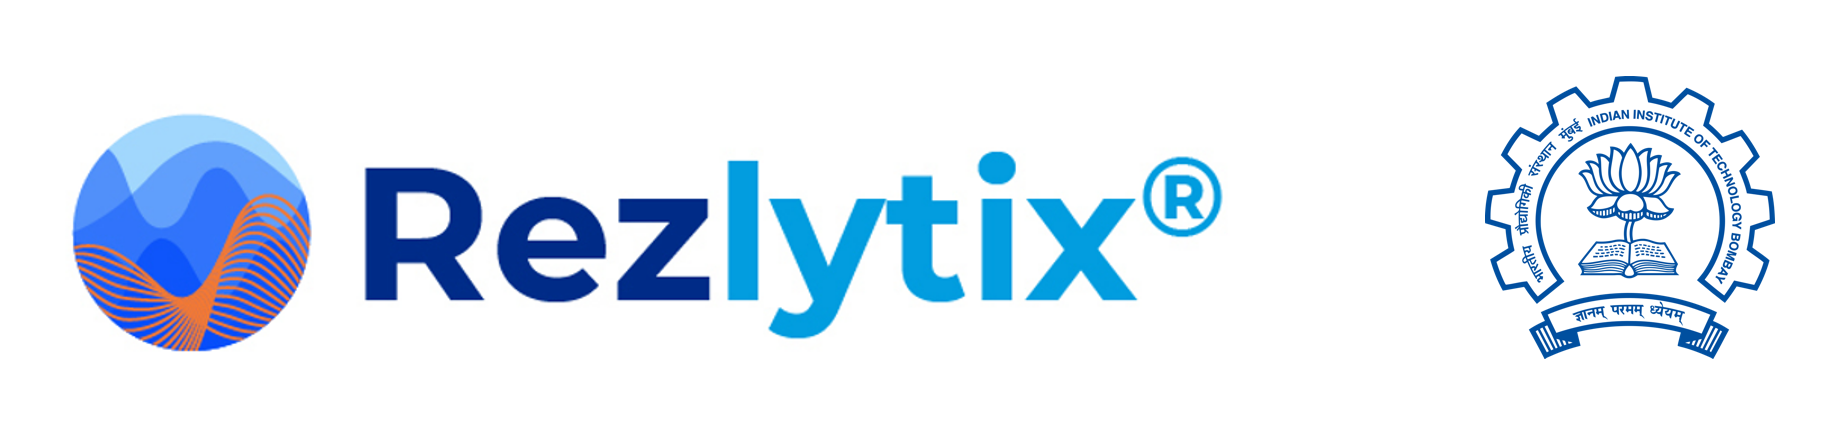

## Notebook overview

* Seismic Well ties in python





# Seismic Well Ties 


-----

In [ ]:
##### Applicable only if you are running this notebook on Colab. Disble otherwise.
##### Mount your google drive to this notebook. It will require some permissions.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define base working directory for this session. Same as the one created earlier.
import os
# base_dir = "/content/drive/My Drive/<Your_folder_name>"     # Please change path / folder name as required. 
base_dir ="/content/drive/MyDrive/Colab Notebooks/workshop_data"
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

if not os.path.isdir(base_dir + "/loaded"):
    os.mkdir(base_dir + "/loaded")

os.chdir(base_dir)

**Please ensure that the sample data folder (workshop_data) that we have provided is inside this base directory.**

### Required libraries

Let's first get all the required libraries.
Since some of these have fairly specific / limited usage, they are usually not part of the standard set of libraries already installed within Colab.

In [ ]:
# Imports for JupyterLite
%pip install -q ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [ ]:
# Let's first install a few uncommon libraries to this environment.
!pip install lasio
!pip install wget
!pip install segyio
!pip install segysak
!pip install pydantic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 KB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=7187160780fdc0f5c75e6380ec76caeb55b91f65b6b54d6bee26a6026f8fdb74
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 KB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.

Other common libraries you will need in this notebook. Please install them if you don't already have them. These come pre-installed in Colab.

* numpy
* scipy
* pandas
* matplotlib
* seaborn
* plotly

In [ ]:
# Scientific and data analysis libraries

import pandas as pd
import numpy as np
import numpy.linalg as LA
from numpy.polynomial.polynomial import polyfit
import xarray as xr
import math
from math import sqrt

import scipy
from scipy import interpolate as interp
from scipy.interpolate import CloughTocher2DInterpolator, griddata
from scipy import signal
from scipy.signal import savgol_filter, correlate, coherence, hilbert, periodogram, welch, butter, lfilter
from scipy.spatial import KDTree, cKDTree, distance
from scipy.fftpack import ifft,fftshift,fft
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from functools import reduce

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as transforms
from matplotlib import gridspec
from matplotlib.pyplot import cm
from matplotlib.cbook import flatten
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipyw

# Typesafe coding
from pydantic import BaseModel, Field
from typing import Any, Optional,List, Union
from typing import Dict, Union
from typing_extensions import Annotated, Literal

# Generic libraries
import os
import time
import shutil
from shutil import copyfile
import warnings

warnings.filterwarnings("ignore")

mpl.rc('font', size=20)
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format

# Use if you want to remove limits on the max no. of rows visible in a dataframe
# pd.set_option('display.max_rows', None)

------

## Seismic well ties

Well-to-seismic ties is an extremely important step within seismic interpretation and inversion.<br> 

It allows us to relate features from the well data such as formation tops, the position of a fault, where we have core intervals in the section to peaks and troughs on the seismic line that passes through the well location or close to the well location.<br>

While this is a standard within most industry standard interpretation softwares, let's dive into how you would perform this yourself using Python.<br><br>
The steps involved are as follows:
1. Data preparation
2. Depth to Time domain conversion
3. Extract seismic traces at well location
4. Wavelet Extraction



### Data preparation

We shall use the csvs in the "xyt" directory to obtain the time-depth relationship at regular depth intervals of the well. The times refer to seismic two-way traveltimes in milliseconds. <br>
The entries also include the coordinates of the well at each interval. This indicates that the wells are deviated.

In [ ]:
# Wells under consideration
wells_list  = ['15_9-F-11A',  '15_9-F-1A', '15_9-F-1B',  '15_9-F-11T2']

In [ ]:
well_name=wells_list[0]

In [ ]:
# Read in the time-depth data "
df_xyt = pd.read_csv(base_dir + '/xyt/' + well_name + '.csv')
df_xyt = df_xyt[['Depth(m)', 'TWT(ms)', 'X(m)', 'Y(m)']]
df_xyt

,Depth(m),TWT(ms),X(m),Y(m)
0,2577.000,2288.706,434598.840,6478426.505
1,2577.100,2288.771,434598.882,6478426.522
2,2577.200,2288.836,434598.923,6478426.539
3,2577.300,2288.901,434598.965,6478426.556
4,2577.400,2288.966,434599.007,6478426.573
...,...,...,...,...
11459,3722.900,2608.384,435284.084,6479014.040
11460,3723.000,2608.399,435284.146,6479014.114
11461,3723.100,2608.413,435284.209,6479014.187
11462,3723.200,2608.427,435284.272,6479014.261


In [ ]:
# Function to prepare data for seaimic well ties
def sw_tie_well_data_prep(df=None, df_xyt=None):
    
    # Obtain the interpolated TWT, X & Y coordinates from the time-depth dataframe created earlier.
    df['TWT(ms)']=np.interp(df['DEPTH'],df_xyt['Depth(m)'],df_xyt['TWT(ms)'])
    df['X(m)']=np.interp(df['DEPTH'],df_xyt['Depth(m)'],df_xyt['X(m)'])
    df['Y(m)']=np.interp(df['DEPTH'],df_xyt['Depth(m)'],df_xyt['Y(m)'])

    #unit convert to µs/m (SI units)
    df['DT(µs/m)'] = df['DT'] / 0.3048 

    #unit convert to kg/m3 (SI units)
    df['RHOB(kg/m3)'] = df['RHOB'] * 1000  

    # Sonic velocity calculation
    #(unit: m/s)
    df['Vsonic(m/s)'] = 1e6/np.array(df['DT(µs/m)'])

    # Acoustic Impedance calculation
    #(unit: kg/m2.s)
    df['AI(kg/m2.s)'] = np.array(df['Vsonic(m/s)']) * np.array(df['RHOB(kg/m3)']) 


    return df


In [ ]:
def load_las_xr_to_df(well_name: str, 
                      las_xr_dir: str):
    """
        Function to load well xarrays to a dataframe

        Args:
            well_name (str): the name of the well
            las_xr_dir (str): the location of the xarray files

        Returns:
            dataframe: the well data.
    """
    xr_list = os.listdir(las_xr_dir)                                    # Creating a list of all available xarray files
    file_to_load = [file for file in xr_list if well_name in file]      # Identify the file for the current well

    well_xr = xr.open_dataset(las_xr_dir + file_to_load[0])
    well_df = well_xr.to_dataframe()
    well_df.reset_index(inplace=True)
    return well_df

In [ ]:
well_ds_dff = load_las_xr_to_df(well_name = well_name, 
                                las_xr_dir = base_dir + '/loaded/')

In [ ]:
well_ds_dff=sw_tie_well_data_prep(df=well_ds_dff,df_xyt=df_xyt)

In [ ]:
well_ds_dff

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT,DTS,TWT(ms),X(m),Y(m),DT(µs/m),RHOB(kg/m3),Vsonic(m/s),AI(kg/m2.s)
0,188.500,NaN,NaN,4.300,NaN,NaN,NaN,NaN,NaN,2288.706,434598.840,6478426.505,NaN,NaN,NaN,NaN
1,188.600,NaN,NaN,3.801,NaN,NaN,NaN,NaN,NaN,2288.706,434598.840,6478426.505,NaN,NaN,NaN,NaN
2,188.700,NaN,NaN,4.301,NaN,NaN,NaN,NaN,NaN,2288.706,434598.840,6478426.505,NaN,NaN,NaN,NaN
3,188.800,NaN,NaN,4.600,NaN,NaN,NaN,NaN,NaN,2288.706,434598.840,6478426.505,NaN,NaN,NaN,NaN
4,188.900,NaN,NaN,4.599,NaN,NaN,NaN,NaN,NaN,2288.706,434598.840,6478426.505,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35730,3761.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2608.442,435284.334,6479014.335,NaN,NaN,NaN,NaN
35731,3761.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2608.442,435284.334,6479014.335,NaN,NaN,NaN,NaN
35732,3761.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2608.442,435284.334,6479014.335,NaN,NaN,NaN,NaN
35733,3761.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2608.442,435284.334,6479014.335,NaN,NaN,NaN,NaN


### Depth  to time domain conversion

In [ ]:
def data_tdom_resample(df=None,features=None,well_sample_rate_twt=None):
    df_dict=dict()
    df_dict['TWT(ms)']= np.arange(df['TWT(ms)'].min(),df['TWT(ms)'].max(),well_sample_rate_twt)
    
    xnew=np.arange(df['TWT(ms)'].min(),df['TWT(ms)'].max(),well_sample_rate_twt)
    
    for a in range(len(features)):
      x=df['TWT(ms)']
      y=np.array(df[features[a]])
      f=np.interp(xnew,x,y)
      df_dict[features[a]]=f
    
    dfD=pd.DataFrame.from_dict(df_dict)
    
    #Reflectivity (Rc) calculation
    Imp = dfD['AI(kg/m2.s)'].values
    Rc=[]
    for i in range(len(Imp)-1):
        Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

    # to adjust vector size copy the last element to the tail
    Rc.append(Rc[-1])

    # Let's add Rc into the existing well dataframe as a new column
    dfD['Rc'] = pd.Series(Rc, index=dfD.index)
    dfD['DEPTH']=np.interp(dfD['TWT(ms)'],df['TWT(ms)'],df['DEPTH'])
    dfD.reset_index(inplace=True,drop=True)
    return dfD

In [ ]:
dt = 0.2  #sampling interval in milliseconds
features=['DEPTH','DT(µs/m)','RHOB(kg/m3)', 'Vsonic(m/s)', 'AI(kg/m2.s)', 'TWT(ms)', 'X(m)','Y(m)']

# to adjust vector size copy the last element to the tail
well_ds_dff_tdom=data_tdom_resample(df=well_ds_dff,features=features,well_sample_rate_twt=dt)
well_ds_dff_tdom

,TWT(ms),DEPTH,DT(µs/m),RHOB(kg/m3),Vsonic(m/s),AI(kg/m2.s),X(m),Y(m),Rc
0,2288.706,2577.000,358.875,2347.000,2786.488,6539887.553,434598.840,6478426.505,-0.004
1,2288.906,2577.308,364.150,2361.161,2746.123,6484038.170,434598.969,6478426.557,0.012
2,2289.106,2577.620,355.995,2363.000,2809.116,6637941.944,434599.099,6478426.609,0.021
3,2289.306,2577.942,342.497,2372.111,2919.906,6926397.555,434599.233,6478426.664,0.005
4,2289.506,2578.271,341.355,2386.000,2929.500,6989788.038,434599.370,6478426.720,-0.028
...,...,...,...,...,...,...,...,...,...
1594,2607.506,3716.541,257.869,2502.044,3877.981,9702913.059,435280.107,6479009.362,0.036
1595,2607.706,3718.065,246.356,2566.417,4059.178,10417622.300,435281.060,6479010.483,-0.050
1596,2607.906,3719.586,277.948,2620.164,3597.814,9426928.228,435282.011,6479011.602,-0.031
1597,2608.106,3720.972,277.871,2462.697,3598.794,8862750.513,435282.878,6479012.621,0.003


#### Visualize the well on a basemap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def basemap_well_plot(df_seis_header=None,df_xyt=None):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.scatterplot(x=np.array(df_seis_header['cdp_x']),y=np.array(df_seis_header['cdp_y']))
  plt.plot(df_xyt['X(m)'],df_xyt['Y(m)'],color='red')
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.title('BaseMap',weight='bold', fontsize=20)
  plt.show()

In [ ]:
# Load the survey file that was created during SEG-Y loading. Please update the file name as required
df_seis_header = pd.read_csv(base_dir + '/loaded/seis_xr_sample_survey.csv')

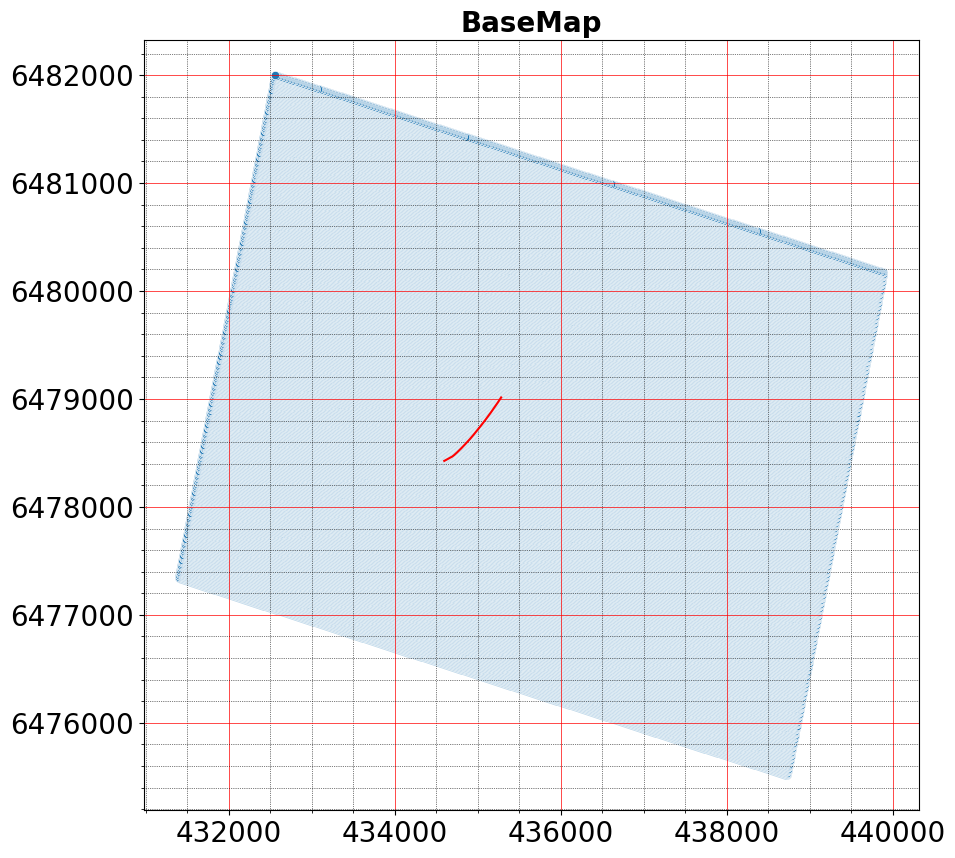

In [ ]:
basemap_well_plot(df_seis_header=df_seis_header, df_xyt=df_xyt)

In [ ]:
df_seis_header.head()

,Trace,cdp_x,cdp_y,iline,xline
0,0,438727.110,6475514.370,9985,1932
1,1,438714.980,6475517.390,9985,1933
2,2,438702.850,6475520.410,9985,1934
3,3,438690.720,6475523.440,9985,1935
4,4,438678.590,6475526.460,9985,1936


## seismic extract

In [ ]:
# Reload the xarray file that had been created during the Data Loading session. Please update path / filename as required.
seisnc_3d = xr.open_dataset(base_dir + '/loaded/seis_xr_sample.nc')

In [ ]:
seisnc_3d

<xarray.Dataset>
Dimensions:  (twt: 1126, xline: 605, iline: 385)
Coordinates:
  * twt      (twt) float64 0.0 4.0 8.0 12.0 ... 4.492e+03 4.496e+03 4.5e+03
  * xline    (xline) int16 1932 1933 1934 1935 1936 ... 2532 2533 2534 2535 2536
    cdp_x    (iline, xline) float32 ...
    cdp_y    (iline, xline) float32 ...
  * iline    (iline) int16 9985 9986 9987 9988 9989 ... 10366 10367 10368 10369
Data variables:
    data     (iline, xline, twt) float32 ...
Attributes: (12/15)
    ns:                  0
    sample_rate:         4.0
    text:                C 1 CLIENT=STATOIL,      PROCESSED BY=WESTERNGECO\nC...
    measurement_system:  m
    d3_domain:           0
    epsg:                0
    ...                  ...
    srd:                 0
    datatype:            0
    percentiles:         [-0.07840206 -0.07584466 -0.01054202  0.          0....
    coord_scalar:        -100.0
    domain:              TWT
    datum:               msl

In [ ]:
df_seis_header

,Trace,cdp_x,cdp_y,iline,xline
0,0,438727.110,6475514.370,9985,1932
1,1,438714.980,6475517.390,9985,1933
2,2,438702.850,6475520.410,9985,1934
3,3,438690.720,6475523.440,9985,1935
4,4,438678.590,6475526.460,9985,1936
...,...,...,...,...,...
232920,232920,432610.970,6481986.380,10369,2532
232921,232921,432598.840,6481989.400,10369,2533
232922,232922,432586.710,6481992.430,10369,2534
232923,232923,432574.580,6481995.450,10369,2535


In [ ]:
#nearest_seismic Trace
from scipy.spatial import KDTree
def nearest_seismic_trace(df_seis_header=None,df=None,seisnc_3d=None):
  tree = KDTree(np.c_[np.array(df_seis_header['cdp_x']), np.array(df_seis_header['cdp_y'])])
  X_=df['X(m)'].mean()
  Y_=df['Y(m)'].mean()
  node=(X_,Y_)
  H1,H=tree.query([node], k=1)
  df_seis_headerWell=df_seis_header.iloc[H]
  ss=seisnc_3d.sel(iline=list(df_seis_headerWell['iline'])[0])
  ss=ss.sel(xline=list(df_seis_headerWell['xline'])[0])
  #vertical seismic trace
  df['Seismic']=np.interp(np.array(df['TWT(ms)']),np.array(ss.twt.data),np.array(ss.data.data))
  return df,df_seis_headerWell

In [ ]:
well_ds_dff_tdom,df_seis_headerWell=nearest_seismic_trace(df_seis_header=df_seis_header,df=well_ds_dff_tdom,seisnc_3d=seisnc_3d)
well_ds_dff_tdom

,TWT(ms),DEPTH,DT(µs/m),RHOB(kg/m3),Vsonic(m/s),AI(kg/m2.s),X(m),Y(m),Rc,Seismic
0,2288.706,2577.000,358.875,2347.000,2786.488,6539887.553,434598.840,6478426.505,-0.004,0.004
1,2288.906,2577.308,364.150,2361.161,2746.123,6484038.170,434598.969,6478426.557,0.012,0.004
2,2289.106,2577.620,355.995,2363.000,2809.116,6637941.944,434599.099,6478426.609,0.021,0.004
3,2289.306,2577.942,342.497,2372.111,2919.906,6926397.555,434599.233,6478426.664,0.005,0.004
4,2289.506,2578.271,341.355,2386.000,2929.500,6989788.038,434599.370,6478426.720,-0.028,0.004
...,...,...,...,...,...,...,...,...,...,...
1594,2607.506,3716.541,257.869,2502.044,3877.981,9702913.059,435280.107,6479009.362,0.036,-0.006
1595,2607.706,3718.065,246.356,2566.417,4059.178,10417622.300,435281.060,6479010.483,-0.050,-0.006
1596,2607.906,3719.586,277.948,2620.164,3597.814,9426928.228,435282.011,6479011.602,-0.031,-0.006
1597,2608.106,3720.972,277.871,2462.697,3598.794,8862750.513,435282.878,6479012.621,0.003,-0.006


### Wavelet estimation

####https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet

In [ ]:
# Function to obtain ricker wavelet
def ricker(f=30,length=0.2, dt=0.002,p=0):
    t = np.arange(-length/2, (length-dt)/2, dt)
    pi=np.pi
    s = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    phase=p*( pi/180)
    h=hilbert(s)
    s1= math.cos(phase)*h.real - math.sin(phase)*h.imag 
    rw = s1;
    return t,rw

In [ ]:
# Visualization function for wavelet
def wavelet_visual(DFb2Wav,well_SampleRate_ms):
  fig = plt.figure(figsize=(40,10))
  gs = gridspec.GridSpec(1,2)
  ax0 = fig.add_subplot(gs[0])
  ax0.plot(DFb2Wav['Time'],DFb2Wav['Wave Amplitude'])
  ax0.set_xlabel("Time(s)")
  ax0.set_ylabel("Amplitude")
  ax0.grid(True)
  ax0.set_xlim(-0.075,0.075)
  ax0.margins(x=0)
  Y1= np.fft.fft(np.array(DFb2Wav['Wave Amplitude']))
  freq = np.fft.fftfreq(len(np.array(DFb2Wav['Wave Amplitude'])), well_SampleRate_ms/1000)
  dfFt=pd.DataFrame(freq,columns=['Freq'])
  dfFt['Amplitude']=np.abs(Y1)/len(np.array(DFb2Wav['Wave Amplitude']))
  dfFt=dfFt[dfFt['Freq']>=0]
  ax1 = fig.add_subplot(gs[1])
  ax1.plot(dfFt['Freq'],dfFt['Amplitude'])
  ax1.set_ylabel('Amplitude')
  ax1.set_xlabel('Frequency')
  ax1.axis(xmin = 0)
  ax1.axis(ymin = 0)
  ax1.set_xlim(0,250)
  ax1.grid(True)
  plt.show()

In [ ]:
# Create ricker wavelet
f=15       #wavelet dominant frequency
length=0.15   #Wavelet vector length
phase=0      #phase
t0, w = ricker (f, length, dt/ 1000,p=phase) # ricker wavelet 


df_b_to_wav=pd.DataFrame()
df_b_to_wav['Wave Amplitude']=w
df_b_to_wav['Time']=t0

well_ds_dff_tdom['Synthetic'] = np.convolve( np.array(well_ds_dff_tdom['Rc']),w, mode='same')
data_Syn=well_ds_dff_tdom
a=np.array(data_Syn['Synthetic'])
b=np.array(data_Syn['Seismic'])
corr, _ = pearsonr(a,b)
print('Correlation SW Tie Full Well '+str(well_name) +' : '+ str(np.round(corr,2)))


Correlation SW Tie Full Well 15_9-F-11A : 0.68


In [ ]:
well_ds_dff_tdom

,TWT(ms),DEPTH,DT(µs/m),RHOB(kg/m3),Vsonic(m/s),AI(kg/m2.s),X(m),Y(m),Rc,Seismic,Synthetic
0,2288.706,2577.000,358.875,2347.000,2786.488,6539887.553,434598.840,6478426.505,-0.004,0.004,0.017
1,2288.906,2577.308,364.150,2361.161,2746.123,6484038.170,434598.969,6478426.557,0.012,0.004,0.017
2,2289.106,2577.620,355.995,2363.000,2809.116,6637941.944,434599.099,6478426.609,0.021,0.004,0.017
3,2289.306,2577.942,342.497,2372.111,2919.906,6926397.555,434599.233,6478426.664,0.005,0.004,0.018
4,2289.506,2578.271,341.355,2386.000,2929.500,6989788.038,434599.370,6478426.720,-0.028,0.004,0.017
...,...,...,...,...,...,...,...,...,...,...,...
1594,2607.506,3716.541,257.869,2502.044,3877.981,9702913.059,435280.107,6479009.362,0.036,-0.006,0.061
1595,2607.706,3718.065,246.356,2566.417,4059.178,10417622.300,435281.060,6479010.483,-0.050,-0.006,0.059
1596,2607.906,3719.586,277.948,2620.164,3597.814,9426928.228,435282.011,6479011.602,-0.031,-0.006,0.057
1597,2608.106,3720.972,277.871,2462.697,3598.794,8862750.513,435282.878,6479012.621,0.003,-0.006,0.056


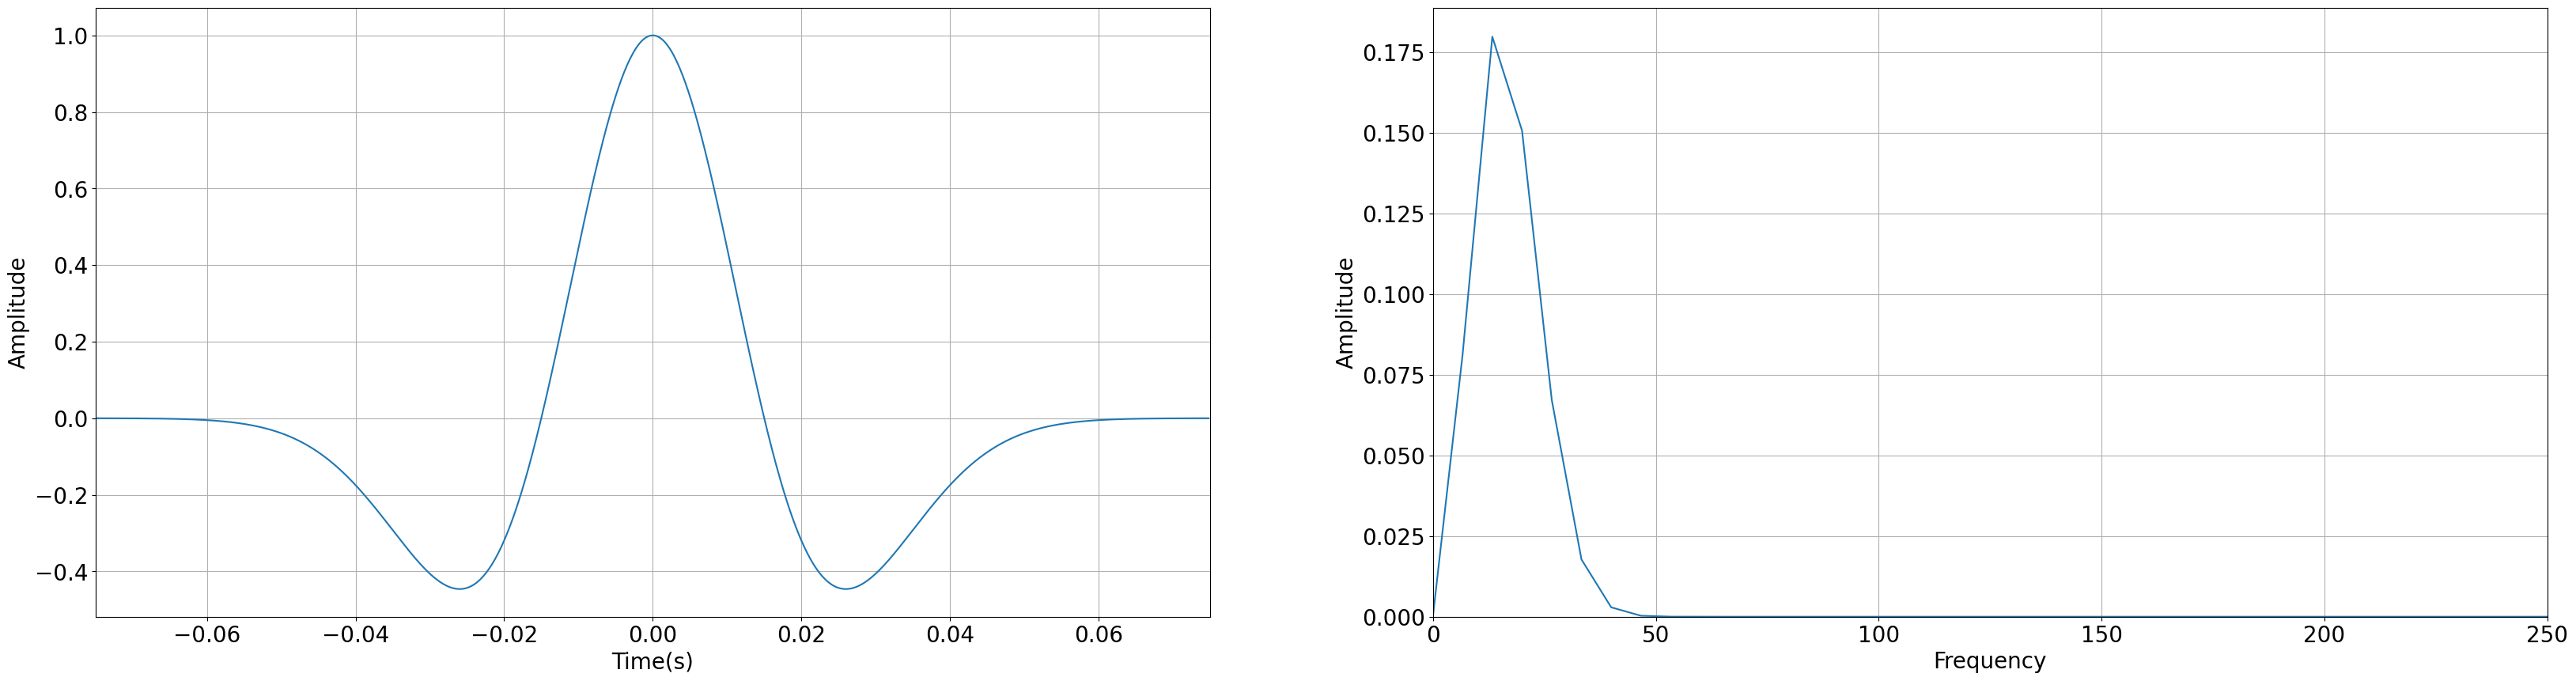

In [ ]:
wavelet_visual(df_b_to_wav,dt)

### 1d visualization

In [ ]:
def sw_tie_plot_1d(df=None):
  fig, axs = plt.subplots(1, 6, figsize = (14,10))
  fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
  m=0
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['DT(µs/m)'], df['TWT(ms)'],'c', alpha=0.8)
  axs[m].set_title('DT ', style = 'normal')
  axs[m].set_xlabel( r'$\mu s/m $', fontsize = '12')
  axs[m].invert_yaxis()
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=True)
  m=m+1
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['RHOB(kg/m3)'], df['TWT(ms)'],'r', alpha=0.6)
  axs[m].set_xlabel('$kg/cc$', fontsize = '12')
  axs[m].set_title('RHOB ', style = 'normal')
  axs[m].invert_yaxis()
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  m=m+1
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['AI(kg/m2.s)'], df['TWT(ms)'],'k', alpha=0.8)
  axs[m].set_title('AI(kg/m2.s)', style = 'normal')
  axs[m].set_xlabel( r'$kg/m^2s^2$', fontsize = '12')
  axs[m].invert_yaxis()
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  m=m+1
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['Rc'], df['TWT(ms)'],'k', alpha=0.8)
  axs[m].set_title('Reflection', style = 'normal')
  axs[m].set_xlabel('fraction' , fontsize = '12')
  axs[m].invert_yaxis()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  axs[m].grid()
  m=m+1
  # -----------------------------------------------------------------------------------track5------------
  df['Synthetic']=(df['Synthetic']-df['Synthetic'].mean())/df['Synthetic'].std()
  for p in range(0,10,2):
    axs[m].plot( df['Synthetic']+p, df['TWT(ms)'] ,'b')
    axs[m].fill_betweenx(df['TWT(ms)'], np.array(df['Synthetic'])+p, p,  np.array(df['Synthetic']) > 0,  color='b')
  axs[m].set_title('Synthetic', style = 'normal')
  plt.setp(axs[m].get_yticklabels(), visible=False)
  axs[m].set_xticks([])
  axs[m].invert_yaxis()
  axs[m].grid()
  m=m+1
  # -----------------------------------------------------------------------------------track6------------
  df['Seismic']=(df['Seismic']-df['Seismic'].mean())/df['Seismic'].std()
  for p in range(0,10,2):
    axs[m].plot( df['Seismic']+p, df['TWT(ms)'] ,'r')
    axs[m].fill_betweenx(df['TWT(ms)'], np.array(df['Seismic'])+p, p,  np.array(df['Seismic']) > 0,  color='r')
  axs[m].set_title('Seismic', style = 'normal')
  axs[m].invert_yaxis()
  axs[m].set_xticks([])
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  plt.show()

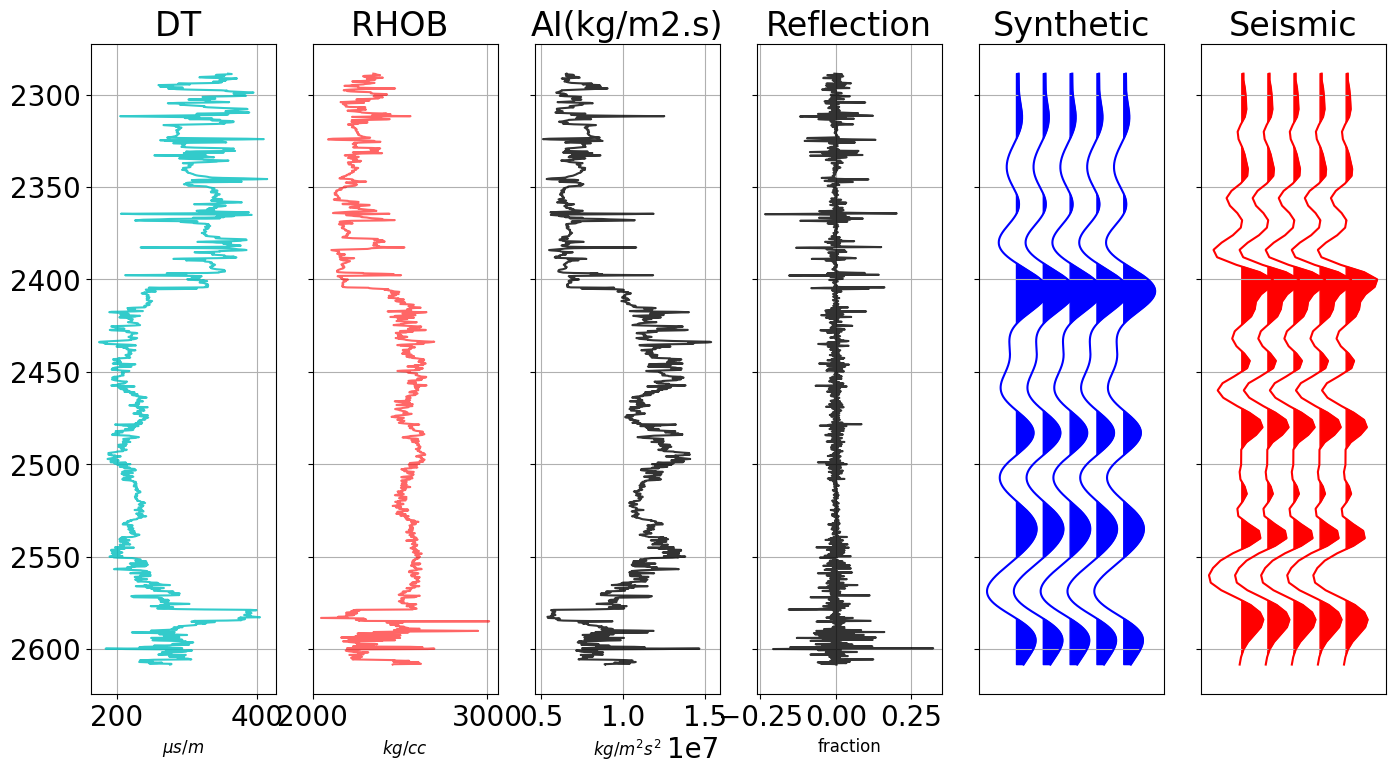

In [ ]:
sw_tie_plot_1d(df=well_ds_dff_tdom)

### 2d visualization

In [ ]:
def sw_tie_2d(df=None,seisnc=None,df_seis_headerWell=None,vm_percen=99,plot_direction='iline'):
  if plot_direction=='iline':
    other_direction='xline'
    ss=seisnc.sel(iline=list(df_seis_headerWell[plot_direction])[0])
    title='seismic_iline_'+str(list(df_seis_headerWell[plot_direction])[0])
    extent=[np.min(ss.xline.data),np.max(ss.xline.data),np.max(ss.twt.data),np.min(ss.twt.data)]
  elif plot_direction=='xline':
    other_direction='iline'
    ss=seisnc.sel(xline=list(df_seis_headerWell[plot_direction])[0])
    title='seismic_xline_'+str(list(df_seis_headerWell[plot_direction])[0])
    extent=[np.min(ss.iline.data),np.max(ss.iline.data),np.max(ss.twt.data),np.min(ss.twt.data)]
 
  dfseis=pd.DataFrame(ss.data.data).T
  twt_resample=np.arange(df['TWT(ms)'].min(),df['TWT(ms)'].max(),ss.sample_rate)
  syn=signal.resample(np.array(df['Synthetic']),twt_resample.shape[0])
  f3 = plt.figure(figsize=[16,12])
  plot=plt.imshow(dfseis,aspect='auto',cmap='gray_r',interpolation='bilinear',vmin=-np.nanpercentile(dfseis,vm_percen),vmax=np.nanpercentile(dfseis,vm_percen),extent=extent)
  plt.title(title)
  plt.xlabel(other_direction)
  plt.ylabel('twt')
  gain_synth =10
  plt.axvline(x=list(df_seis_headerWell[other_direction])[0], color='k', label='axvline - full height')
  plt.plot(syn*gain_synth+list(df_seis_headerWell[other_direction])[0],twt_resample , 'k')
  plt.fill_betweenx(twt_resample,syn*gain_synth+list(df_seis_headerWell[other_direction])[0],  list(df_seis_headerWell[other_direction])[0], 
                   syn*gain_synth+list(df_seis_headerWell[other_direction])[0] > list(df_seis_headerWell[other_direction])[0],
                  color = 'k', alpha = 0.5)
  plt.ylim(df['TWT(ms)'].max()+100,df['TWT(ms)'].min()-100)
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  f3.colorbar(plot, cax=cax, orientation='vertical')
  plt.show()



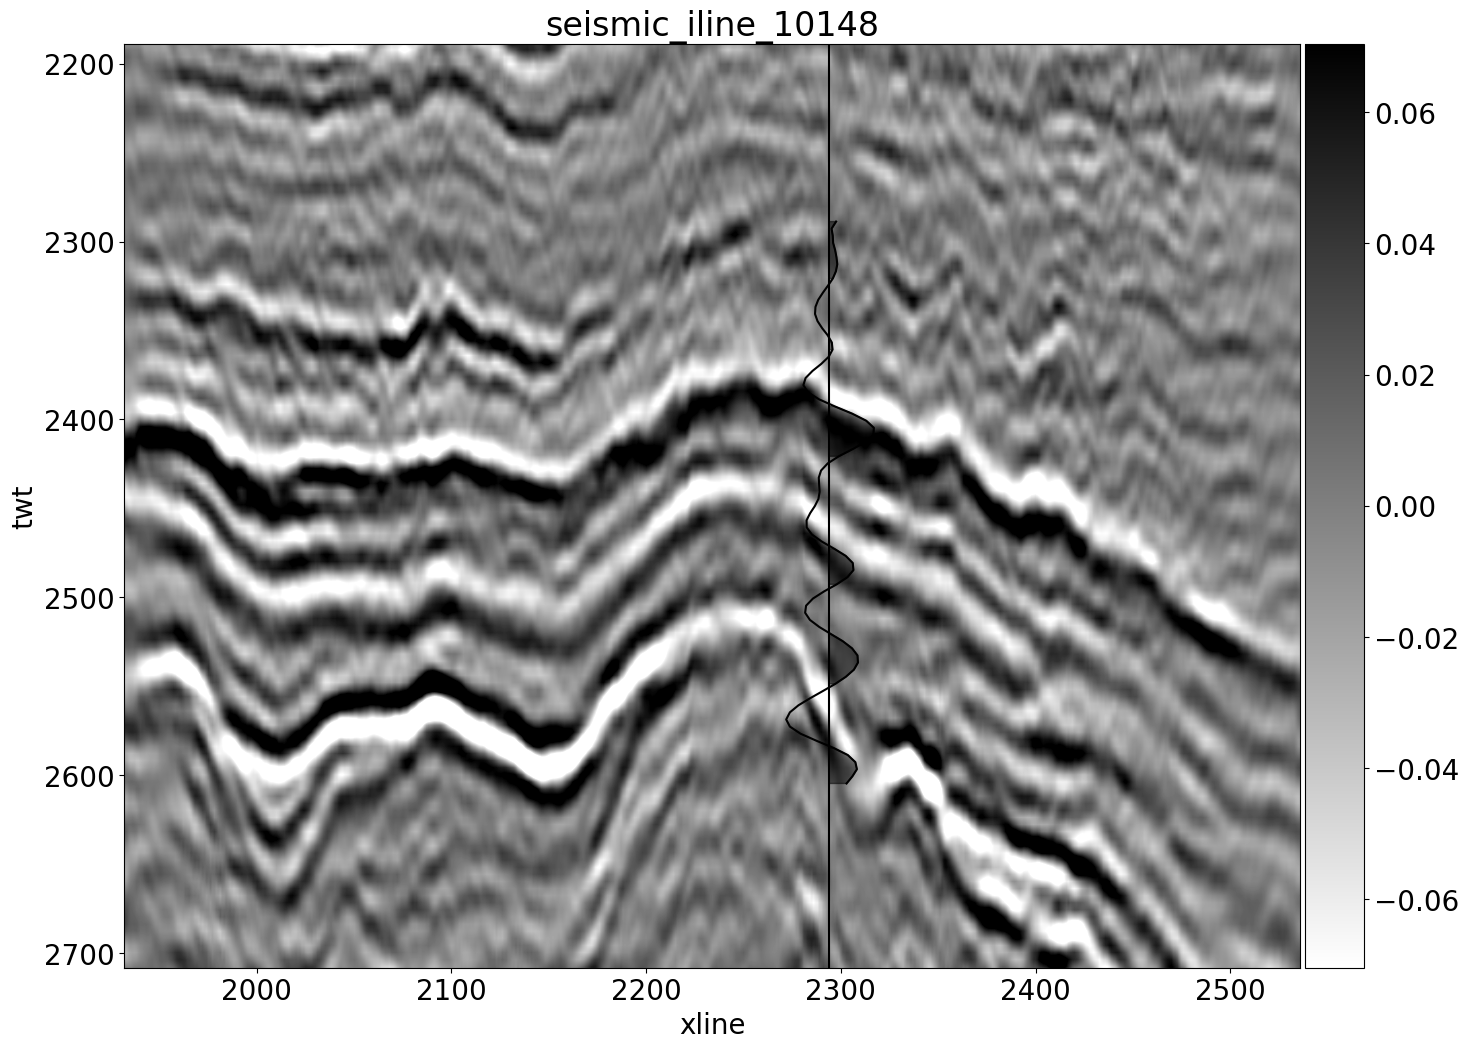

In [ ]:
sw_tie_2d(df=well_ds_dff_tdom, 
          seisnc=seisnc_3d,
          df_seis_headerWell=df_seis_headerWell,
          vm_percen=99,plot_direction='iline')

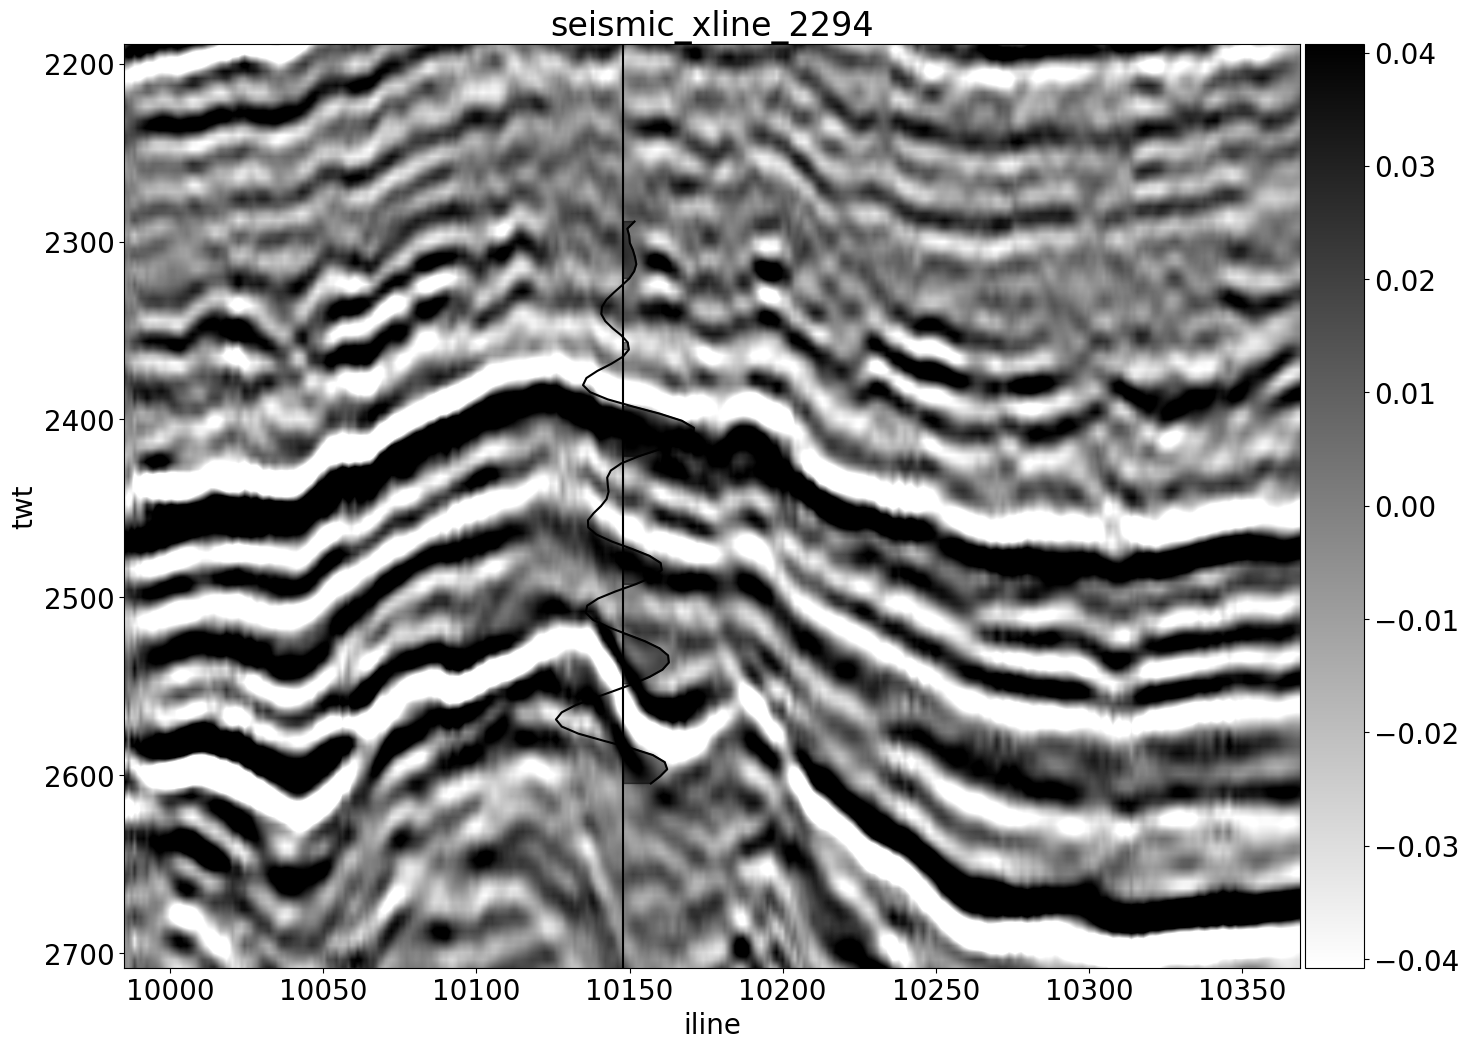

In [ ]:
sw_tie_2d(df=well_ds_dff_tdom, 
          seisnc=seisnc_3d,
          df_seis_headerWell=df_seis_headerWell,
          vm_percen=95,plot_direction='xline')